In [1]:
# !pip install seqeval

In [2]:
!pip install pytorch transformers tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ps3d9has/pytorch_a9355a9c7bea48ac9810fa8149cbfbb3/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ps3d9has/pytorch_a9355a9c7bea48ac9810fa8149cbfbb3/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-biq54kbk/install-record.txt --single-version-externally-managed --compile --install-headers /usr/

In [3]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import torch
import transformers

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup 

In [5]:
df = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [6]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [7]:
df["Sentence #"] = df["Sentence #"].fillna(method="ffill")

In [8]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
words_list = list(set(df["Word"].values))

print(f"There are {len(words_list)} words.")

words_list[:10]

There are 35178 words.


['Macy',
 'Lakers',
 'rustlers',
 'tax',
 'scares',
 'Bangguo',
 'unappreciated',
 'Samana',
 'al-Zawahiri',
 'bypass']

In [10]:
tags_values = df["Tag"].unique().tolist() + ['PAD']
tags_and_index = {}
for index, tag in enumerate(tags_values):
    tags_and_index[tag] = index

In [11]:
tags_and_index

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16,
 'PAD': 17}

In [12]:
df.groupby("Tag").count()

,Sentence #,Word,POS
Tag,,,
B-art,402,402,402
B-eve,308,308,308
B-geo,37644,37644,37644
B-gpe,15870,15870,15870
B-nat,201,201,201
B-org,20143,20143,20143
B-per,16990,16990,16990
B-tim,20333,20333,20333
I-art,297,297,297


In [13]:
sentences = df.groupby('Sentence #').apply(lambda sentence: sentence['Word'].tolist()).tolist()
labels = df.groupby('Sentence #').apply(lambda sentence: sentence['Tag'].tolist()).tolist()

In [14]:
def tokenize_and_get_labels(sentences, initial_labels):
    sent_tokenized = []
    labels = []
    for word, label in zip(sentences, initial_labels):
        tokenized_word = tokenizer.tokenize(word)
        sent_tokenized = sent_tokenized + tokenized_word
        labels = labels + ([label] * len(tokenized_word))
    return sent_tokenized, labels

In [15]:
def getDataset(sentences, labels, tokenizer, tags_and_index, max_len):
        tokens_ = []; labels_ = []
        for i, sentence in enumerate(sentences):
            tok, lab = tokenize_and_get_labels(sentence, labels[i])
            tokens_.append(tokenizer.convert_tokens_to_ids(["[CLS]"] + tok))
            labels_.append([tags_and_index.get(l) for l in (["O"] + lab)])
        input_ids = pad_sequences(tokens_, maxlen=max_len, dtype="long", truncating="post", padding="post")
        tags = pad_sequences(labels_, maxlen=max_len, value=tags_and_index["PAD"], padding="post", dtype="long", truncating="post")
        pad_tok = tokenizer.vocab["[PAD]"]
        sep_tok = tokenizer.vocab["[SEP]"]
        o_lab = tags_and_index["O"]
        attention_masks = []
        for index, tag_ids in enumerate(tags):
            if input_ids[i][-1] != pad_tok:
                input_ids[i][-1] = sep_tok
                tag_ids[-1] = o_lab
            attention_masks.append([float(i != 0.0) for i in input_ids[i]])
        return input_ids, tags, attention_masks

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [17]:
print(len(sentences), len(labels))
input_ids, tags, attention_masks = getDataset(sentences, labels, tokenizer, tags_and_index, 64)

47959 47959


In [18]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, tags, test_size=0.1)
masks_train, masks_val, _, _ = train_test_split(attention_masks, input_ids, test_size=0.1)

In [19]:
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
masks_train = torch.tensor(masks_train)
masks_val = torch.tensor(masks_val)

In [20]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([43163, 64]),
 torch.Size([4796, 64]),
 torch.Size([43163, 64]),
 torch.Size([4796, 64]))

In [21]:
batch_size = 32
train_data = TensorDataset(X_train, masks_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_data = TensorDataset(X_val, masks_val, y_val)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda')

In [35]:
model = BertForTokenClassification.from_pretrained("bert-base-cased",output_attentions=False, output_hidden_states=False,num_labels=len(tags_and_index))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [36]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01
)

In [37]:
from sklearn.metrics import f1_score, classification_report

In [38]:
model = model.to(device)

In [39]:
loss_values = []
validation_loss_values = []
epochs = 10
for _ in trange(epochs, desc="Epoch"):
    # Start training
    model.train()
    total_loss = 0
    for step, (batch_input_ids, batch_input_mask, batch_labels) in enumerate(train_dataloader):
        batch_input_ids, batch_input_mask, batch_labels = batch_input_ids.to(device), batch_input_mask.to(device), batch_labels.to(device)
        model.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_input_mask, labels=batch_labels, token_type_ids=None)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    
    # Start Validation
    model.eval()
    
    val_loss = 0
    accuracy = 0
    val_steps = 0
    predictions , true_labels = [], []
    with torch.no_grad():
        for (batch_input_ids, batch_input_mask, batch_labels) in valid_dataloader:
            batch_input_ids, batch_input_mask, batch_labels = batch_input_ids.to(device), batch_input_mask.to(device), batch_labels.to(device)
            outputs = model(batch_input_ids, attention_mask=batch_input_mask, labels=batch_labels, token_type_ids=None)
            logits = outputs[1].detach().cpu().numpy()
            label_ids = batch_labels.to('cpu').numpy()
            val_loss += outputs[0].mean().item()
            predictions_flattened = np.argmax(logits, axis=2).reshape(-1)
            labels_flattened = label_ids.reshape(-1)
            accuracy += np.mean(labels_flattened == predictions_flattened)
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.extend(label_ids)
            val_steps += 1
    val_loss = val_loss / val_steps
    validation_loss_values.append(val_loss)

    pred_tags = [tags_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tags_values[l_i] != "PAD"]
    valid_tags = [tags_values[l_i] for l in true_labels
                                  for l_i in l if tags_values[l_i] != "PAD"]
    
    print(f"Loss: {val_loss}, Accuracy: {accuracy / val_steps}, F1-Score: {f1_score(valid_tags, pred_tags, average='macro')}, F1-Score(micro): {f1_score(valid_tags, pred_tags, average='micro')}")

Epoch:  10%|█         | 1/10 [02:20<21:08, 141.00s/it]

Loss: 0.05776069237540166, Accuracy: 0.9821991257440476, F1-Score: 0.4735875827501249, F1-Score(micro): 0.9566122102119752


Epoch:  20%|██        | 2/10 [04:41<18:47, 140.90s/it]

Loss: 0.05407104078680277, Accuracy: 0.983100818452381, F1-Score: 0.6074581934919796, F1-Score(micro): 0.9588121768550801


Epoch:  30%|███       | 3/10 [07:02<16:26, 140.94s/it]

Loss: 0.05113571859275301, Accuracy: 0.9837779017857142, F1-Score: 0.6081079055965231, F1-Score(micro): 0.9604641373668702


Epoch:  40%|████      | 4/10 [09:23<14:05, 140.86s/it]

Loss: 0.053023280718674265, Accuracy: 0.9842810639880952, F1-Score: 0.6512895814642766, F1-Score(micro): 0.9616951656328676


Epoch:  50%|█████     | 5/10 [11:44<11:44, 140.90s/it]

Loss: 0.057241838512321314, Accuracy: 0.9841652715773809, F1-Score: 0.6569271054715291, F1-Score(micro): 0.9614092493904425


Epoch:  60%|██████    | 6/10 [14:05<09:23, 140.97s/it]

Loss: 0.061158713002999625, Accuracy: 0.9842392113095239, F1-Score: 0.6499906851690446, F1-Score(micro): 0.9615919181008807


Epoch:  70%|███████   | 7/10 [16:26<07:02, 140.95s/it]

Loss: 0.06735008515417576, Accuracy: 0.9843536086309524, F1-Score: 0.6627597589179185, F1-Score(micro): 0.9618619501076157


Epoch:  80%|████████  | 8/10 [18:47<04:41, 140.99s/it]

Loss: 0.06983103745306532, Accuracy: 0.9842666480654761, F1-Score: 0.6835463315052016, F1-Score(micro): 0.9616475129257968


Epoch:  90%|█████████ | 9/10 [21:08<02:20, 140.95s/it]

Loss: 0.07611847647776206, Accuracy: 0.9840485491071428, F1-Score: 0.6631070490193787, F1-Score(micro): 0.9611153910301721


Epoch: 100%|██████████| 10/10 [23:29<00:00, 140.95s/it]

Loss: 0.08060544437418381, Accuracy: 0.9835797991071428, F1-Score: 0.6512307774344136, F1-Score(micro): 0.9599796681783165


In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [42]:
conf_matrix = confusion_matrix(valid_tags, pred_tags)

In [43]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
tags_ = [pad for pad in tags_and_index.keys() if pad not in  ["PAD", np.nan]]

In [45]:
tags_.sort()

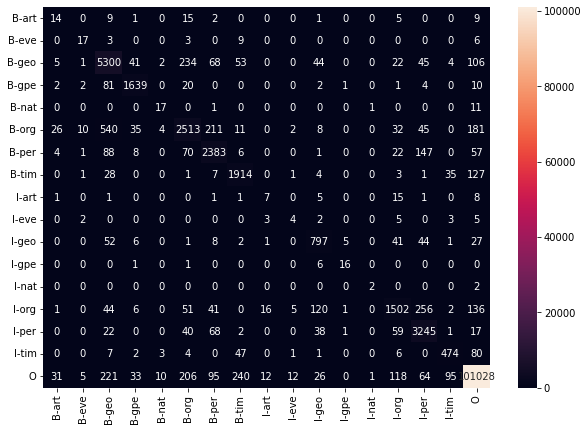

In [46]:
df_cm = pd.DataFrame(conf_matrix, index = tags_,
                  columns = tags_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.6g')